### Connecting Google Drive to this notebook to match any external files we have created and utilize in this part.
(e.g. annotation schema and related keywords, JSON web token for the service account that we can use to make changes in our BigQuery, etc)

In [ ]:
# link this notebook to my google drive so I can retrieve data files from there
# Import the dedicated library
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing libraries and dependencies

In [ ]:
# for data loading, handling, and visualizations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for nlp
import re
import nltk
from nltk import ne_chunk, pos_tag, word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import wordnet

# for stopwords, I will only drop those of small length that could mess with abbreviations
stop_words = [word for word in stopwords.words('english') if len(word) <= 3]

import spacy
from spacy.tokens import DocBin
from spacy.training import Example
!python -m spacy download en_core_web_sm  # this is the model I will retrain because it is the smallest and most efficient (although less accurate)
%pip install spacy-transformers  # necessary to (re)train spacy ner models
import spacy_transformers

# for statistical models
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics

# for DL-based models
from transformers import pipeline, DistilBertForTokenClassification, DistilBertTokenizerFast
from datasets import Dataset, load_metric

# random utilities
from tqdm import tqdm
import json
import os
import subprocess
import time
from collections import Counter



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Importing the annotation schema and label-related words.
These words will be used to create sophisticated regex patterns to automatically match relevant utterances across the whole dataset very quickly.

In [ ]:
label_terms = dict()
with open('/content/drive/MyDrive/NLP_project/sample_custom_ner/my_categories/all_relevant_fixed.csv', 'r') as f:
  for line in f:
    line = line.rstrip().split(',')
    label = line[0]
    if label == '': continue
    terms = [i for i in line[1:] if (not i!=i) and (i!='')]  # filtering out missing values - NaNs are unequal to themselves
    label_terms[label] = set(terms)

In [ ]:
label_terms.keys()

dict_keys(['GENERIC', 'MEDICAL-CONDITIONS', 'SYMPTOMS', 'TREATMENTS', 'POLICIES', 'METRICS'])

In [ ]:
my_labels = list(label_terms.keys()) + ['ORGANIZATION']
orgs_vals = pd.read_csv('/content/drive/MyDrive/NLP_project/sample_custom_ner/my_categories/organizations.csv', header=None, index_col=False, encoding='utf-8', sep=',')
from itertools import chain
label_terms[my_labels[-1]] = set(i for i in chain.from_iterable(orgs_vals.values))

In [ ]:
print(label_terms['ORGANIZATION'])

{'un', 'biontech', 'bbibp-corv', 'national health system', 'soberana', 'united nations', 'coronavac', 'centers for disease control and prevention', 'jnj', 'cansinobio', 'vaxzevria', 'sputnik', 'finlay institute', 'johns hopkins university', 'bharat biotech', 'vector institute', 'jannsen', 'cdc', 'shifa pharmed', 'covaxin', 'center for genetic engineering', 'spikevax', 'covovax', 'convidecia', 'comirnaty', 'sinovac', 'national institutes of health', 'food and drug administration', 'pfizer', 'epivaccorona', 'sinopharm', 'johnson & johnson', 'j&j', 'moderna', 'coviran', 'novavax', 'astrazeneca', 'nhs', 'gamaleya', 'fda', 'w.h.o.', 'nih', 'world health organization', 'bill & melinda gates foundation'}


### Importing the Dataset with which we're going to work - 'uns_covid1' BigQuery table.

In [ ]:
!pip install google-cloud-bigquery
!pip install db-dtypes

In [ ]:
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()

# BigQuery client
project_id = 'nlp-project-427710'
client = bigquery.Client(project=project_id)

# SQL query to fetch data from BigQuery table
query = """
    SELECT status_id, text
    FROM `nlp-project-427710.covid.uns_covid1`
    WHERE lang='en'
    LIMIT 100000
"""

# Fetch data me to BigQuery client
df = client.query(query).to_dataframe()

In [ ]:
df.head()

,status_id,text
0,1245406137236615169,COVID-19 India Update : Total Active Cases : 1...
1,1245415621648678912,U.S.: #Florida governor issues stay-at-home or...
2,1245425967469924354,Guyana: Aviation authority extends suspension ...
3,1245455807812173824,"Canada: #WindsorInternationalAirport, #Ontario..."
4,1245492693368819715,"Canada: #AirCanada suspends flights to, from s..."


In [ ]:
# making sure that there is no overlap whatsoever between the labels
for i in range(1,len(my_labels)):
  if label_terms[my_labels[i-1]].intersection(label_terms[my_labels[i]]) != set():
    print(my_labels[i-1], my_labels[i])
    print(label_terms[my_labels[i-1]].intersection(label_terms[my_labels[i]]))

In [ ]:
my_labels

['GENERIC',
 'MEDICAL-CONDITIONS',
 'SYMPTOMS',
 'TREATMENTS',
 'POLICIES',
 'METRICS',
 'ORGANIZATION']

### Creating patterns to match against each of the categories in the annotation schema.
Implementing manual annotation for every single tweet is extremely time-consuming and agent-dependent, so we will try to do our best to create training data by annotating based on RegEx matches.

We will instead follow a custom approach for each of the annotation schema's categories, and check the results of each implementation on some sample data before moving on to the next category.

Then, we will create json files containing training/testing data in the same form as the output of the NER annotator.

We convert each of these json file's entities to SpaCy DocBins, so we can create the .spacy files to be used in training and testing the spacy model.

In [ ]:
# This is a generic regex pattern to match exact terms from each label.
# All the specified terms are standalone words/phrases - smaller ones like 'icu' could match with (e.g.) 'difficult', destroying the efficiency of my algo.
# So I make sure to take that into account in the pattern, by surrounding everything with '\b'.
# I also add words/phrases in the pattern based on their (character) length in descending order, so longer utterances are
# matched first (e.g. 'covid-19' instead of 'covid'), and then I have created a function to make sure that we do not
# perform double annotations over the same term ('good_entity()').


# LONGER TERMS ARE MATCHED FIRST!
def create_pattern(terms):
    sorted_terms = sorted(terms, key=len, reverse=True)
    escaped_terms = [re.escape(term) for term in sorted_terms]
    pattern = r'\b(?:' + '|'.join(escaped_terms) + r')\b'
    return re.compile(pattern, re.IGNORECASE)


In [ ]:
### PATTERN FOR 'GENERIC'

pattern_1 = re.compile(r'(#?(?:corona\w*|covid[-\w\d]*)\s+(?:pandemic|epidemic|infections|infection|outbreak)|#?corona[-\S]+|#?covid[-\S\d]+)', re.IGNORECASE)
# This will match:
#   '#corona' or 'corona' +any_word_sequence in a single word
#   '#covid' or 'covid' +any_word_or_dash_and_number_sequence in a single utterance (e.g. covid-sars)
#   'covid...' or 'corona...' + generic pandemic-related words like outbreak/infection/...
# We have opted NOT to capture outbreak/infection/... on their own, they are too generic.

In [ ]:
# Checking the results - seem adequate, so we keep this as it is
t = [i for i in df['text'][:50].str.findall(pattern_1) if i]
t

[['COVID-19', '#Covid_19', '#CoronaUpdate', '#COVID2019India'],
 ['#COVID19'],
 ['#COVID19'],
 ['#COVID19;'],
 ['#COVID19'],
 ['#COVID19'],
 ['#COVID19'],
 ['#COVID19'],
 ['#COVID19 outbreak'],
 ['#COVID19'],
 ['#Coronavirus'],
 ['#Coronavirus'],
 ['coronavirus,', '#COVID19', '#coronavirus'],
 ['coronavirus,', '#COVID19', '#coronavirus'],
 ['#COVID2019india',
  '#COVID2019',
  'COVID19',
  '#CoronaVirus',
  '#COVID19',
  '#CoronaOutbreak'],
 ['#COVID19'],
 ['#COVID19:'],
 ['coronavirus', 'coronavirus', 'coronavirus', '#coronavirus', '#covid19'],
 ['#coronavirus', '#covid_19'],
 ['Coronavirus:', '#COVID19'],
 ['#coronavirus'],
 ['#coronavirus'],
 ['#Coronavirus Outbreak'],
 ['#coronavirus'],
 ['#Coronavirus:'],
 ['#COVID19'],
 ['#Coronavirus:', '#COVID-19'],
 ['#coronavirus'],
 ['Coronavirus', '#Covid19'],
 ['#coronavirus'],
 ['Covid-19', '#covid19', '#coronavirus'],
 ['coronavirus pandemic', '#covid19'],
 ['Coronavirus', '#Coronavirus'],
 ['COVID-19', '#COVID19'],
 ['#covid19'],
 ['#CO

In [ ]:
### PATTERN FOR MEDICAL-CONDITIONS
# For these words I just want to do exact matches - too generic and risky otherwise
pattern_2 = create_pattern(label_terms['MEDICAL-CONDITIONS'])

In [ ]:
label_terms['MEDICAL-CONDITIONS']

{'acute respiratory distress syndrome',
 'adult respiratory distress syndrome',
 'coagulopathy',
 'cytokine storm',
 'discriminating',
 'kidney injury',
 'long covid',
 'multi-organ failure',
 'pneumonia',
 'respiratory',
 'sickness',
 'wet lung',
 'white lung'}

In [ ]:
# Checking the results - seem adequate, so we keep this as it is
t = [i for i in df['text'][:1000].str.findall(pattern_2) if i]
t

[['respiratory'], ['pneumonia'], ['Respiratory'], ['cytokine storm']]

In [ ]:
### PATTERN FOR SYMPTOMS - EXACT MATCHING ONLY
pattern_3 = create_pattern(label_terms['SYMPTOMS'])

In [ ]:
# Checking the results - seem adequate, so we keep this as it is
t = [i for i in df['text'][:1000].str.findall(pattern_3) if i]
t

[['cough'], ['coughing', 'cough']]

In [ ]:
### PATTERN FOR TREATMENTS - EXACT MATCHING
pattern_4 = create_pattern(label_terms['TREATMENTS'])

# Checking the results - seem adequate, so we keep this as it is
t = [i for i in df['text'][:1000].str.findall(pattern_4) if i]
t

[['ventilator'],
 ['vaccine'],
 ['Plasma'],
 ['surgery'],
 ['Surgery'],
 ['Vaccine'],
 ['vaccines'],
 ['ventilators'],
 ['azithromycin'],
 ['ventilator'],
 ['Ventilators'],
 ['ventilators'],
 ['Vaccine']]

In [ ]:
### PATTERN FOR ORGANIZATIONS - EXACT MATCHING
pattern_5 = create_pattern(label_terms['ORGANIZATION'])

# Checking the results - seem adequate, so we keep this as it is
t = [i for i in df['text'][:1000].str.findall(pattern_5) if i]
t

[['NHS'],
 ['NHS'],
 ['NHS'],
 ['NHS'],
 ['NHS'],
 ['FDA', 'FDA'],
 ['CDC'],
 ['World Health Organization'],
 ['World Health Organization', 'CDC', 'CDC'],
 ['CDC'],
 ['CDC'],
 ['CDC'],
 ['CDC'],
 ['CDC'],
 ['NHS'],
 ['NHS'],
 ['NHS']]

In [ ]:
### PATTERN FOR POLICIES - EXACT MATCHING
pattern_6 = create_pattern(label_terms['POLICIES'])

# Checking the results - seem adequate, so we keep this as it is
t = [i for i in df['text'][:150].str.findall(pattern_6) if i]
t

[['stay-at-home'],
 ['lockdown'],
 ['Quarantine', 'quarantine'],
 ['social distancing'],
 ['social distancing'],
 ['social distancing'],
 ['Stay-at-Home'],
 ['lockdown'],
 ['closure'],
 ['lockdown'],
 ['QUARANTINE']]

In [ ]:
### PATTERN FOR METRICS
# HERE I HAVE 2 CASES THAT I WANT TO MATCH, BUT THE FIRST ONE IS MORE SIGNIFICANT THAN THE OTHER

# 1st case: number followed by exact utterance in label_terms list
number_word_pattern = r'\b\d+(?:[.,]\d+)*\s*(?:' + '|'.join(re.escape(word) for word in label_terms['METRICS']) + r')\b'

# 2nd case: if a number-utterance does not exist, then just match the exact utteranc in list
standalone_word_pattern = r'\b(?:' + '|'.join(re.escape(word) for word in label_terms['METRICS']) + r')\b'

# Combined pattern
pattern_7= re.compile(rf'({number_word_pattern})|({standalone_word_pattern})', re.IGNORECASE)

# Checking the results - seem adequate, so we keep this as it is
# need to refine my result-returning expression to avoid getting empty strings for no matches in one of the two alternative patterns
t = [[match[0] if match[0] else match[1] for match in i] for i in df['text'][:200].str.findall(pattern_7) if i]
t

[['Cases', 'Recovered', 'Deaths'],
 ['patients'],
 ['tests'],
 ['cases'],
 ['cases'],
 ['patients'],
 ['2148 cases', '30 deaths', '85 recoveries'],
 ['2119 cases', '27 deaths', '85 recoveries'],
 ['cases'],
 ['cases'],
 ['cases'],
 ['200,000 cases', 'case'],
 ['cases', 'cases']]

In [ ]:
# Creating a dictionary matching each label of the annotation schema to its corresponding pattern:
label_to_pattern_dict = {
    'GENERIC': pattern_1,
 'MEDICAL-CONDITIONS': pattern_2,
 'SYMPTOMS': pattern_3,
 'TREATMENTS': pattern_4,
  'ORGANIZATION': pattern_5,
 'POLICIES': pattern_6,
 'METRICS': pattern_7
}

In [ ]:
# For the NER task, we are going to perform very minimal pre-processing, only removing urls (that are very common and do not provide any semantic value)
# and convert everything to the lower case.
def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # We do NOT remove hashtags, as they are typically related to the pandemic or used to make
    # references to specific aspects, policies, or other terms related to it.
    # We also do NOT drop user mentions ('@...') since they are widely used to refer to organizations.
    #tweet = tweet.strip()
    # I do not need to remove stopwords + the corresponding operation would have an annoying effect of
    # adding a space character between a '#'/'@' and its text
    return tweet

In [ ]:
# FROM THE DOCUMENTATION: `re.finditer` returns an iterator yielding 'Match' objects over all
        # NON-overlapping matches for the 'pattern' in 'tweet' - so I do not need to worry using 'good_entity'
        # `re.finditer()` returns None for no matches, so the loop would not execute for such tweets.
            #print(match)
def extract_entities(tweet, patterns):
  entities = []
  for label, pattern in patterns.items():
      for match in re.finditer(pattern, tweet):
          start_idx, end_idx = match.span()
          entities.append((start_idx, end_idx, label))
  return entities

In [ ]:
# Create SpaCy tuples from DataFrame
def create_spacy_tuples(df, text_column, patterns):
    spacy_data = []
    for tweet in df[text_column]:
        tweet = preprocess_tweet(tweet)
        entities = extract_entities(tweet, patterns)
        spacy_data.append((tweet, {"entities": entities}))
    return spacy_data

In [ ]:
# This is to check how annotation went based on our regex patterns, and potentially make any changes before training the actual models

def create_annotated_json(filename):
    # we have no duplicates, so I arbitrarily choose the training and test sets based on index
    if filename.find('train') != -1:
      data = create_spacy_tuples(df.iloc[:10000], 'text', label_to_pattern_dict)
    elif filename.find('test') != -1:
      data = create_spacy_tuples(df.iloc[10000:20000], 'text', label_to_pattern_dict)
    else:
      raise Exception("'train' or 'test' needs to be mentioned in filename")
    annotation_dataset_path = '/content/drive/MyDrive/NLP_project/sample_custom_ner/annotations_dataset'
    full_path = f"{annotation_dataset_path}/{filename}"

    with open(full_path, 'w', encoding='utf-8') as f:
        f.write(json.dumps(data) + "\n")
        print('done')

create_annotated_json('_training_data.json')
create_annotated_json('_testing_data.json')

done
done


In [ ]:
# finding the character boundaries of matches - we opted for the more efficient 'extract_entities' function at the end.
def find_boundaries(string, terms, labels):
  end_s = ''
  for i in range(len(terms)):
    term = terms[i]
    label = labels[i]
    if i != len(terms)-1:
      end_s += f'[{string.find(term)},{string.find(term)+len(term)},"{label}"], '
    else:
      end_s += f'[{string.find(term)},{string.find(term)+len(term)},"{label}"]'
  print(end_s)

In [ ]:
def save_spacy_format_from_json(json_filename, spacy_filename, sample_size):
    annotation_dataset_path = '/content/drive/MyDrive/NLP_project/sample_custom_ner/annotations_dataset'
    json_path = f"{annotation_dataset_path}/{json_filename}"
    spacy_path = f"{annotation_dataset_path}/{spacy_filename}"

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    nlp = spacy.blank("en")
    db = DocBin()

    for i, (text, annot) in enumerate(data):
        if i >= sample_size:
            break
        doc = nlp.make_doc(text)
        ents = []
        spans = []
        for start, end, label in annot['entities']:
            span = doc.char_span(start, end, label=label, alignment_mode='contract')
            if span is None:
                print(f"Skipping invalid entity in text: {text[start:end]}")
            else:
                ents.append(span)
                spans.append((start, end, label))

        # Check for overlapping spans
        spans.sort()  # Sort by start index
        valid_ents = []
        last_end = -1
        for span in ents:
            if span.start_char >= last_end:
                valid_ents.append(span)
                last_end = span.end_char
            else:
                print(f"Skipping overlapping entity in text: {span.text}")

        doc.ents = valid_ents
        db.add(doc)
    db.to_disk(spacy_path)


# Create training and testing files for different sample sizes
train_sample_sizes = [500, 1000, 2000, 5000, 10000]
test_sample_size = 10000

# Create training datasets
for sample_size in train_sample_sizes:
    train_json_filename = '_training_data.json'
    train_spacy_filename = f'my_train_data_{sample_size}.spacy'
    save_spacy_format_from_json(train_json_filename, train_spacy_filename, sample_size)

# Create testing dataset
test_json_filename = '_testing_data.json'
test_spacy_filename = 'my_dev_data.spacy'
save_spacy_format_from_json(test_json_filename, test_spacy_filename, test_sample_size)

Streaming output truncated to the last 5000 lines.
Skipping overlapping entity in text: lockdown
Skipping overlapping entity in text: cases
Skipping overlapping entity in text: deaths
Skipping invalid entity in text: covid19
Skipping overlapping entity in text: cdc
Skipping overlapping entity in text: lockdown
Skipping invalid entity in text: covid19
Skipping overlapping entity in text: cytokine storm
Skipping invalid entity in text: covid19
Skipping overlapping entity in text: quarantine
Skipping overlapping entity in text: quarantine
Skipping overlapping entity in text: quarantine
Skipping overlapping entity in text: cdc
Skipping overlapping entity in text: cases
Skipping overlapping entity in text: cdc
Skipping invalid entity in text: cdc
Skipping overlapping entity in text: tests
Skipping overlapping entity in text: social distancing
Skipping overlapping entity in text: quarantine
Skipping overlapping entity in text: icu
Skipping overlapping entity in text: patients
Skipping overla

## INITIALIZING THE CONFIG FILES

In [ ]:
# Paths and configurations
config_path = '/content/drive/MyDrive/NLP_project/sample_custom_ner/config'
annotations_path = '/content/drive/MyDrive/NLP_project/sample_custom_ner/annotations_dataset'
output_base_path = os.path.join(config_path, 'output')


config_files = [
    'base_config_en_gpu_accuracy_retrain.cfg',
    'base_config_en_gpu_efficiency_retrain.cfg',
    'base_config_en_cpu_efficiency_retrain.cfg',
    'base_config_en_cpu_accuracy_null.cfg',
    'base_config_en_cpu_efficiency_null.cfg',
    'base_config_en_cpu_accuracy_retrain.cfg',
    'base_config_en_gpu_efficiency_null.cfg',
    'base_config_en_gpu_accuracy_null.cfg'
]

In [ ]:
### Function to make sure that configuration files are properly initialized
def initialize_configs():
    for base_config_file in config_files:
        base_config_file_path = os.path.join(config_path, base_config_file)
        config_file_name = base_config_file.replace("base_", "")
        config_file_path = os.path.join(config_path, config_file_name)

        try:
            subprocess.run(['python', '-m', 'spacy', 'init', 'fill-config', base_config_file_path, config_file_path], check=True)
            print(f"Configuration file {config_file_path} created successfully.")
        except subprocess.CalledProcessError as e:
            print(f"An error occurred while creating {config_file_path}: {e}")
            print(e.output)

# Ensure configuration files are initialized
initialize_configs()

Configuration file /content/drive/MyDrive/NLP_project/sample_custom_ner/config/config_en_gpu_accuracy_retrain.cfg created successfully.
Configuration file /content/drive/MyDrive/NLP_project/sample_custom_ner/config/config_en_gpu_efficiency_retrain.cfg created successfully.
Configuration file /content/drive/MyDrive/NLP_project/sample_custom_ner/config/config_en_cpu_efficiency_retrain.cfg created successfully.
Configuration file /content/drive/MyDrive/NLP_project/sample_custom_ner/config/config_en_cpu_accuracy_null.cfg created successfully.
Configuration file /content/drive/MyDrive/NLP_project/sample_custom_ner/config/config_en_cpu_efficiency_null.cfg created successfully.
Configuration file /content/drive/MyDrive/NLP_project/sample_custom_ner/config/config_en_cpu_accuracy_retrain.cfg created successfully.
Configuration file /content/drive/MyDrive/NLP_project/sample_custom_ner/config/config_en_gpu_efficiency_null.cfg created successfully.
Configuration file /content/drive/MyDrive/NLP_pro

### TRAINING, SAVING AND EVALUATING THE MODELS

In [ ]:
### Train the models

train_sizes = [500]#, 2000, 10000]  # limited computational resources - we will try with only 500 samples
test_spacy_filename = 'my_dev_data.spacy'

# Function to train and evaluate model
def train_and_evaluate(base_config_file, train_size):
    base_config_file_path = os.path.join(config_path, base_config_file)
    config_file_name = base_config_file.replace("base_", "")
    config_file_path = os.path.join(config_path, config_file_name)

    # Create a unique output path for each combination
    unique_output_path = os.path.join(output_base_path, f"{config_file_name}_train_size_{train_size}")
    os.makedirs(unique_output_path, exist_ok=True)

    os.chdir(config_path)
    subprocess.run(['python', '-m', 'spacy', 'init', 'fill-config', base_config_file_path, config_file_path], check=True)

    os.chdir(annotations_path)
    train_spacy_filename = f'my_train_data_{train_size}.spacy'
    train_command = [
        'python', '-m', 'spacy', 'train', config_file_path, '--output', unique_output_path,
        '--paths.train', train_spacy_filename, '--paths.dev', test_spacy_filename
    ]

    # Add GPU option if config file contains 'gpu' so as to make sure that the model gets trained on it
    if 'gpu' in base_config_file:
        train_command.append('--gpu-id')
        train_command.append('0')

    print(f"Running command: {' '.join(train_command)}")  # Debug print

    try:
        process = subprocess.Popen(train_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)  # this allows us to see the
        # output of the subprocess that we run IN REAL TIME
        for line in process.stdout:
            print(line, end='')
        process.wait()
        if process.returncode != 0:
            print(f"Training command failed with exit code {process.returncode}")
            print(process.stderr.read())
            #return None, unique_output_path
            return unique_output_path
    except subprocess.CalledProcessError as e:
        print(f"Training command failed with exit code {e.returncode}")
        #return None, unique_output_path
        return unique_output_path

    return unique_output_path

# Function to extract metrics from scorer
def extract_metrics(scorer):
    metrics = {
        'overall_precision': scorer["ents_p"],
        'overall_recall': scorer["ents_r"],
        'overall_f1': scorer["ents_f"]
    }
    per_label_scores = scorer["ents_per_type"]
    for label, scores in per_label_scores.items():
        metrics[f'{label}_precision'] = scores["p"]
        metrics[f'{label}_recall'] = scores["r"]
        metrics[f'{label}_f1'] = scores["f"]
    return metrics

# DataFrame to store results
results = []

# Train and evaluate models for each configuration and train size
for base_config_file in config_files:
    for train_size in train_sizes:
        try:
            unique_output_path = train_and_evaluate(base_config_file, train_size)
            print("Training successful:", unique_output_path)
        except Exception as e:
            print(f"An error occurred: {e}")

Running command: python -m spacy train /content/drive/MyDrive/NLP_project/sample_custom_ner/config/config_en_gpu_accuracy_retrain.cfg --output /content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_gpu_accuracy_retrain.cfg_train_size_500 --paths.train my_train_data_500.spacy --paths.dev my_dev_data.spacy --gpu-id 0
ℹ Saving to output directory:
/content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_gpu_accuracy_retrain.cfg_train_size_500
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['transformer', 'ner']
ℹ Initial learn rate: 0.0
E    #       LOSS TRANS...  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  -------------  --------  ------  ------  ------  ------
  0       0        1527.57   1171.74    0.03    0.02    0.18    0.00
 22     200       47982.56  56851.77   83.78   84.

KeyboardInterrupt: 

In [ ]:
# Paths and configurations
config_path = '/content/drive/MyDrive/NLP_project/sample_custom_ner/config'
annotations_path = '/content/drive/MyDrive/NLP_project/sample_custom_ner/annotations_dataset'
output_base_path = os.path.join(config_path, 'output')
train_sizes = [500]
test_spacy_filename = 'my_dev_data.spacy'

config_files = [
    'base_config_en_gpu_accuracy_retrain.cfg',
    'base_config_en_gpu_efficiency_retrain.cfg',
    'base_config_en_cpu_efficiency_retrain.cfg',
    'base_config_en_cpu_accuracy_null.cfg',
    'base_config_en_cpu_efficiency_null.cfg',
    'base_config_en_cpu_accuracy_retrain.cfg',
    'base_config_en_gpu_efficiency_null.cfg',
    'base_config_en_gpu_accuracy_null.cfg'
]

# Function to extract metrics from scorer
def extract_metrics(scorer):
    metrics = {
        'overall_precision': scorer["ents_p"],
        'overall_recall': scorer["ents_r"],
        'overall_f1': scorer["ents_f"]
    }
    per_label_scores = scorer["ents_per_type"]
    for label, scores in per_label_scores.items():
        metrics[f'{label}_precision'] = scores["p"]
        metrics[f'{label}_recall'] = scores["r"]
        metrics[f'{label}_f1'] = scores["f"]
    return metrics

# DataFrame to store results
results = []

for base_config_file in config_files:
    temp_path = os.path.join(output_base_path, base_config_file.replace('base_', '') + '_train_size_500')
    for train_size in train_sizes:
        start_time = time.time()
        try:
            # Verify if the model directory exists
            model_path = os.path.join(temp_path, 'model-best')
            if not os.path.exists(model_path):
                print(f"Model directory not found: {model_path}")
                continue
            else:
                print('Path:', model_path)

            # Load the dev data
            print('\nLoad the dev data:\n')
            dev_data_path = os.path.join(annotations_path, test_spacy_filename)
            doc_bin = DocBin().from_disk(dev_data_path)
            nlp = spacy.blank("en")
            dev_docs = list(doc_bin.get_docs(nlp.vocab))

            # Load the trained model
            print('\nLoad the trained model:\n')
            spacy.prefer_gpu()
            nlp = spacy.load(model_path)

            # Prepare examples for evaluation
            print('\nPrepare examples for evaluation:\n')
            examples = [Example.from_dict(doc, {'entities': [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}) for doc in dev_docs]

            # Evaluate the model
            print('\nEvaluate the model:\n')
            scorer = nlp.evaluate(examples)

            metrics = extract_metrics(scorer)
            metrics['config_file_name'] = base_config_file
            metrics['training_n'] = train_size
            metrics['output_path'] = temp_path
            results.append(metrics)
        except Exception as e:
            print(f"An error occurred: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(config_path, 'training_results.csv'), index=False)

# Display results
print(results_df)


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Path: /content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_gpu_accuracy_retrain.cfg_train_size_500/model-best

Load the dev data:



/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)



Load the trained model:



/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(



Prepare examples for evaluation:


Evaluate the model:

Path: /content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_gpu_efficiency_retrain.cfg_train_size_500/model-best

Load the dev data:


Load the trained model:


Prepare examples for evaluation:


Evaluate the model:

Path: /content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_cpu_efficiency_retrain.cfg_train_size_500/model-best

Load the dev data:


Load the trained model:


Prepare examples for evaluation:


Evaluate the model:

Path: /content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_cpu_accuracy_null.cfg_train_size_500/model-best

Load the dev data:


Load the trained model:


Prepare examples for evaluation:


Evaluate the model:

Path: /content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_cpu_efficiency_null.cfg_train_size_500/model-best

Load the dev data:


Load the trained model:


Prepare examples for evaluation:


Evaluate the

In [ ]:
# Sanity check - we need to get 8 different paths
results_df['output_path'].unique()

array(['/content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_gpu_accuracy_retrain.cfg_train_size_500',
       '/content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_gpu_efficiency_retrain.cfg_train_size_500',
       '/content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_cpu_efficiency_retrain.cfg_train_size_500',
       '/content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_cpu_accuracy_null.cfg_train_size_500',
       '/content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_cpu_efficiency_null.cfg_train_size_500',
       '/content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_cpu_accuracy_retrain.cfg_train_size_500',
       '/content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_gpu_efficiency_null.cfg_train_size_500',
       '/content/drive/MyDrive/NLP_project/sample_custom_ner/config/output/config_en_gpu_accuracy_null.cfg_train

## IMPORTANT NOTE
At first, we let the model with just 500 samples start training with the default `max_steps` parameter value.

However, model's performance metrics (e.g., ENTS_F, ENTS_P, ENTS_R) stabilized around the 3000 to 4000 steps mark. This suggests that extending beyond this point may yield diminishing returns and could potentially lead to overfitting.

So we explicitly asserted `max_epochs` to be equal to 2000 for each '%cpu%' cfg file. To make this equivalent to 'gpu' files so all models effectively go through the entire dataset for the exact same number of times:
- Number of training examples: 500
- Batch size: 128
- Max epochs: 2000

Then the formula to calculate the appropriate 'total_steps' for cpu-based models to train by going through the dataset in the same number of times that their gpu-based counterparts do is:
total_steps = (500×2000)/128 = 7812.5 so (since the no of steps needs to be integer) 7813



Also, we did not want to only retrain a spacy model [created base_configs with [train] > vectors='en_core_web_lg', but also wanted to build our own spacy model using its default [vectors=null] transformers (for '%gpu%' configs - pipeline=['transformer','ner']) or tok2vec embeddings for classification models (for '%cpu%' configs - pipeline=['tok2vec','ner']) from scratch.



In [ ]:
# MY CUSTOM MODELS
# I need to bring X_train, y_train, X_test, y_test in a usable format - IOB/BIO tag scheme
# - B-XXX -> The beginning token of a named entity of type XXX.
# - I-XXX -> Any token inside a named entity of type XXX (but not the first token).
# - O -> A token that is outside any named entity.

In [ ]:
json_data_path = '/content/drive/MyDrive/NLP_project/sample_custom_ner/annotations_dataset/'

with open(json_data_path + '_training_data.json', 'r') as f:
  train_ = json.load(f)

with open(json_data_path + '_testing_data.json', 'r') as f:
  test_ = json.load(f)

# Function to annotate tokens
def annotate_tokens(text, entities):
    tokens = word_tokenize(text)
    ents = []
    len_in = 0

    for token in tokens:
        token_start = text.find(token, len_in)  # Find the correct start index of the token
        token_end = token_start + len(token)
        len_in = token_end  # Update len_in to the end of the current token
        matched = False

        for start_idx, end_idx, label in entities:
            if token_start >= start_idx and token_end <= end_idx:
                if token_start == start_idx:
                    ents.append((token, f"B-{label}"))
                else:
                    ents.append((token, f"I-{label}"))
                matched = True
                break

        if not matched:
            ents.append((token, 'O'))

    return ents




# Process training data - 2D lists containing tokens in the same order as we
# come across them in our data samples, or their corresponding annotations
X_train = []
y_train = []

for text, entity_data in train_:
    entities = entity_data['entities']
    annotated_tokens = annotate_tokens(text, entities)
    X_train.extend([token for token, label in annotated_tokens])
    y_train.extend([label for token, label in annotated_tokens])

# Process testing data - 2D list of the same structure as in the training data
X_test = []
y_test = []

for text, entity_data in test_:
    entities = entity_data['entities']
    annotated_tokens = annotate_tokens(text, entities)
    X_test.extend([token for token, label in annotated_tokens])
    y_test.extend([label for token, label in annotated_tokens])

# Combine y_train and y_test for label encoding
all_labels = y_train + y_test

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Transform tokens using TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split())
X_train_vec = vectorizer.fit_transform([' '.join(tokens) for tokens in X_train])
X_test_vec = vectorizer.transform([' '.join(tokens) for tokens in X_test])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Training the baseline Maximum Entropy Model

In [ ]:
model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_train_vec, y_train_encoded)

# Predict
y_pred_encoded = model.predict(X_test_vec)

# Decode labels back to original
y_pred_lg = label_encoder.inverse_transform(y_pred_encoded)

# Calculate and print overall accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_lg)
print(f"Accuracy: {accuracy:.2f}")

# Calculate and print precision, recall, and F1-score
print(metrics.classification_report(y_test, y_pred_lg))

Accuracy: 0.94


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

           B-GENERIC       0.87      0.06      0.11     14461
B-MEDICAL-CONDITIONS       0.00      0.00      0.00        23
           B-METRICS       0.77      0.39      0.52      2042
      B-ORGANIZATION       0.00      0.00      0.00       204
          B-POLICIES       0.03      0.01      0.01       717
          B-SYMPTOMS       0.00      0.00      0.00        50
        B-TREATMENTS       0.00      0.00      0.00       189
           I-GENERIC       0.92      0.79      0.85     15691
I-MEDICAL-CONDITIONS       0.00      0.00      0.00         3
           I-METRICS       0.00      0.00      0.00       499
      I-ORGANIZATION       0.00      0.00      0.00        23
          I-POLICIES       0.00      0.00      0.00       222
          I-SYMPTOMS       0.00      0.00      0.00        22
        I-TREATMENTS       0.00      0.00      0.00         4
                   O       0.94      1.00      0.97    292145

      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## Showing sample annotations and comparing them with the corresponding manual annotations
k = 0 # token offset to be used to address
for i in range(5):
  text, entity_data = test_[i]
  print('Text to process:', text)
  print('\n')
  tokens = word_tokenize(text)
  n_tokens = len(tokens)
  for z in range(n_tokens):
    print(tokens[z], y_test[k+z], y_pred_lg[k+z])
  k += n_tokens
  print('\n\n')

Text to process: un secy general antonio guterres terms #covid19 a human crisis; calls for coordinated, inclusive, innovative action to combat pandemic. 


un B-ORGANIZATION O
secy O O
general O O
antonio O O
guterres O O
terms O O
# B-GENERIC O
covid19 I-GENERIC I-GENERIC
a O O
human O O
crisis O O
; O O
calls O O
for O O
coordinated O O
, O O
inclusive O O
, O O
innovative O O
action O O
to O O
combat O O
pandemic O O
. O O



Text to process: at the northwest angle, breakup is (mostly) business as usual (despite #coronavirus concerns) 


at O O
the O O
northwest O O
angle O O
, O O
breakup O O
is O O
( O O
mostly O O
) O O
business O O
as O O
usual O O
( O O
despite O O
# B-GENERIC O
coronavirus I-GENERIC I-GENERIC
concerns O O
) O O



Text to process: local health care providers such as @essentiahealth and @cuyunamedcenter face possible hospital bed shortage with #coronavirus 😮 #covid19fccmn 


local O O
health O O
care O O
providers O O
such O O
as O O
@ O O
essentiahealth O O
an

Counter({'O': 267845, 'I-GENERIC': 15666, 'B-GENERIC': 14854, 'B-METRICS': 1264, 'B-POLICIES': 902, 'I-METRICS': 227, 'B-TREATMENTS': 219, 'B-ORGANIZATION': 181, 'I-POLICIES': 178, 'B-SYMPTOMS': 42, 'I-ORGANIZATION': 30, 'B-MEDICAL-CONDITIONS': 28, 'I-SYMPTOMS': 19, 'I-MEDICAL-CONDITIONS': 2, 'I-TREATMENTS': 2})


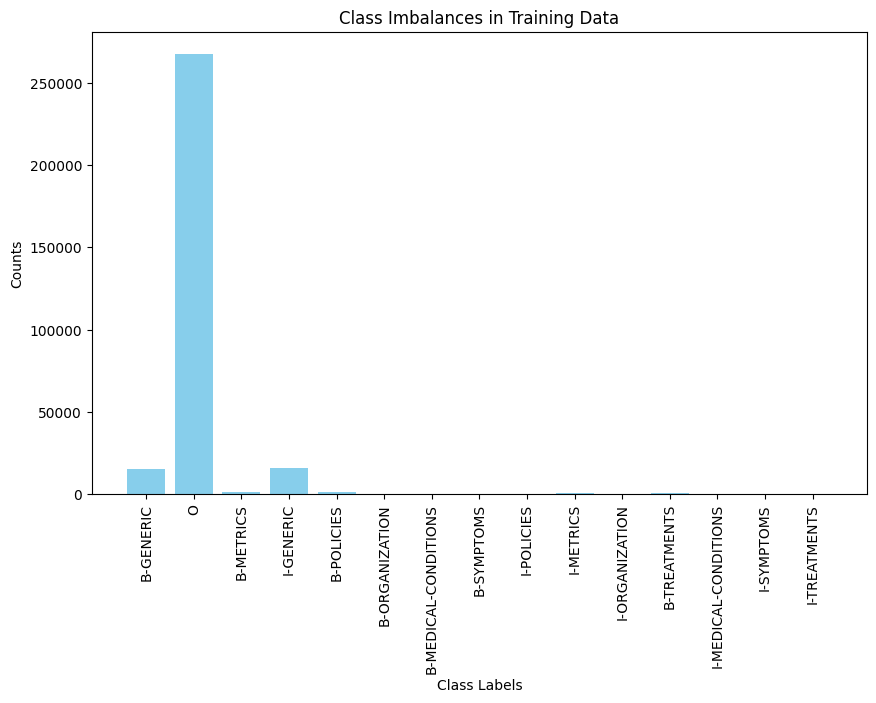

In [ ]:
### Show existing class imbalances by using the 'Counter' method on this container
# Count the occurrences of each class label
class_counts = Counter(y_train)

# Display the class counts
print(class_counts)

# Extract labels and counts
labels, counts = zip(*class_counts.items())

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Counts')
plt.title('Class Imbalances in Training Data')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Performing cross validation to optimize the previous classifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, classification_report, accuracy_score, f1_score
import numpy as np

# Assuming X_train_vec, y_train_encoded, X_test_vec, y_test, label_encoder are defined and preprocessed

# Define custom scorer for macro F1 score
def ner_macro_f1_scorer(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return f1_score(y_true_flat, y_pred_flat, average='macro')

# Create the Logistic Regression model
model = LogisticRegression(multi_class='multinomial', max_iter=1000)

# Define parameter grid including penalty and class_weight
param_grid = {
    'C': [0.1, 1, 10],                       # Regularization strength
    'penalty': ['l1','l2'],                        # Penalty (L1 or L2 regularization)
    'class_weight': [None, 'balanced']        # Class weight to account for class imbalances - did not manage to account for them in train-test-splitting through random under/oversampling
    # or by implementing SMOTE - in the future we would like to enhance our approach on this frontier
}

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(ner_macro_f1_scorer)
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, refit='f1_macro', cv=5, return_train_score=False)

# Perform grid search
grid_search.fit(X_train_vec, y_train_encoded)

# Print best parameters and scores
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation macro F1 score: ", grid_search.best_score_)

# Train final model on full training data with best parameters
best_model = grid_search.best_estimator_

# Predict
y_pred_encoded = best_model.predict(X_test_vec)

# Decode labels back to original
y_pred_lg = label_encoder.inverse_transform(y_pred_encoded)

# Calculate and print overall accuracy
accuracy = accuracy_score(y_test, y_pred_lg)
print(f"Test Accuracy: {accuracy:.2f}")

# Calculate and print precision, recall, and F1-score
print(classification_report(y_test, y_pred_lg, zero_division=0))


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting err

Best parameters found:  {'C': 10, 'class_weight': None, 'penalty': 'l2'}
Best cross-validation macro F1 score:  0.23217996903455007
Test Accuracy: 0.94
                      precision    recall  f1-score   support

           B-GENERIC       0.86      0.06      0.11     14461
B-MEDICAL-CONDITIONS       0.00      0.00      0.00        23
           B-METRICS       0.77      0.44      0.56      2042
      B-ORGANIZATION       0.82      0.42      0.55       204
          B-POLICIES       0.03      0.01      0.01       717
          B-SYMPTOMS       0.00      0.00      0.00        50
        B-TREATMENTS       0.02      0.01      0.01       189
           I-GENERIC       0.91      0.80      0.85     15691
I-MEDICAL-CONDITIONS       0.00      0.00      0.00         3
           I-METRICS       0.00      0.00      0.00       499
      I-ORGANIZATION       0.00      0.00      0.00        23
          I-POLICIES       0.00      0.00      0.00       222
          I-SYMPTOMS       0.00      0.00

In [ ]:
## Showing sample annotations and comparing them with the corresponding manual annotations
k = 0 # token offset to be used to address
for i in range(5):
  text, entity_data = test_[i]
  print('Text to process:', text)
  print('\n')
  tokens = word_tokenize(text)
  n_tokens = len(tokens)
  for z in range(n_tokens):
    print(tokens[z], y_test[k+z], y_pred_lg[k+z])
  k += n_tokens
  print('\n\n')

Text to process: un secy general antonio guterres terms #covid19 a human crisis; calls for coordinated, inclusive, innovative action to combat pandemic. 


un B-ORGANIZATION O
secy O O
general O O
antonio O O
guterres O O
terms O O
# B-GENERIC O
covid19 I-GENERIC I-GENERIC
a O O
human O O
crisis O O
; O O
calls O O
for O O
coordinated O O
, O O
inclusive O O
, O O
innovative O O
action O O
to O O
combat O O
pandemic O O
. O O



Text to process: at the northwest angle, breakup is (mostly) business as usual (despite #coronavirus concerns) 


at O O
the O O
northwest O O
angle O O
, O O
breakup O O
is O O
( O O
mostly O O
) O O
business O O
as O O
usual O O
( O O
despite O O
# B-GENERIC O
coronavirus I-GENERIC I-GENERIC
concerns O O
) O O



Text to process: local health care providers such as @essentiahealth and @cuyunamedcenter face possible hospital bed shortage with #coronavirus 😮 #covid19fccmn 


local O O
health O O
care O O
providers O O
such O O
as O O
@ O O
essentiahealth O O
an

### Implementing a PromptNER model based on the DistilBERT LLM

In [ ]:
!pip install transformers datasets evaluate seqeval


In [ ]:
!pip install transformers[torch]

In [ ]:
# Load data
json_data_path = '/content/drive/MyDrive/NLP_project/sample_custom_ner/annotations_dataset/'

with open(json_data_path + '_training_data.json', 'r') as f:
    train_ = json.load(f)

with open(json_data_path + '_testing_data.json', 'r') as f:
    test_ = json.load(f)

In [ ]:
# Function to annotate tokens
def annotate_tokens(text, entities):
    tokens = word_tokenize(text)
    ents = []
    len_in = 0

    for token in tokens:
        token_start = text.find(token, len_in)
        token_end = token_start + len(token)
        len_in = token_end
        matched = False

        for start_idx, end_idx, label in entities:
            if token_start >= start_idx and token_end <= end_idx:
                if token_start == start_idx:
                    ents.append((token, f"B-{label}"))
                else:
                    ents.append((token, f"I-{label}"))
                matched = True
                break

        if not matched:
            ents.append((token, 'O'))

    return ents


In [ ]:
# Process training data
train_data = {
    "tokens": [],
    "ner_tags": []
}

for text, entity_data in train_:
    entities = entity_data['entities']
    annotated_tokens = annotate_tokens(text, entities)
    train_data["tokens"].append([token for token, label in annotated_tokens])
    train_data["ner_tags"].append([label for token, label in annotated_tokens])

# Process testing data
test_data = {
    "tokens": [],
    "ner_tags": []
}

for text, entity_data in test_:
    entities = entity_data['entities']
    annotated_tokens = annotate_tokens(text, entities)
    test_data["tokens"].append([token for token, label in annotated_tokens])
    test_data["ner_tags"].append([label for token, label in annotated_tokens])


In [ ]:
# Create label mapping
unique_labels = {
    'B-GENERIC',
    'B-MEDICAL-CONDITIONS',
    'B-METRICS',
    'B-ORGANIZATION',
    'B-POLICIES',
    'B-SYMPTOMS',
    'B-TREATMENTS',
    'I-GENERIC',
    'I-MEDICAL-CONDITIONS',
    'I-METRICS',
    'I-ORGANIZATION',
    'I-POLICIES',
    'I-SYMPTOMS',
    'I-TREATMENTS',
    'O'
}
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

# Convert string labels to integer labels
def convert_labels_to_ids(labels, label2id):
    return [[label2id[label] for label in label_list] for label_list in labels]

train_data['ner_tags'] = convert_labels_to_ids(train_data['ner_tags'], label2id)
test_data['ner_tags'] = convert_labels_to_ids(test_data['ner_tags'], label2id)

# Convert to Dataset
train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

In [ ]:
# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Function to prepare few-shot examples
def integrate_prompt_with_few_shot(examples, prompt_template):
    prompts = [
        prompt_template.format(" ".join(tokens)) for tokens in examples["tokens"]
    ]
    examples["prompt"] = prompts
    return examples

# Subset the test data to only 100 examples
test_data_subset = {
    "tokens": test_data["tokens"][:100],
    "ner_tags": test_data["ner_tags"][:100]
}

# Create a few-shot prompt template
schema_definition = """
Entity Types for COVID-19 Tweets
1. GENERIC: General mentions to the COVID-19 pandemic and its implications, e.g., generic hashtags like "#coronavirus".
2. MEDICAL-CONDITIONS: mentions to medically recognized and named health conditions (not symptoms) related to covid e.g., "long covid", "wet lung", "adult respiratory distress syndrome", "cytokine storm".
3. SYMPTOMS: mentions to symptoms of covid19 e.g., "cough", "sepsis", "weariness", "hypoxemia", "shortness of breath".
4. TREATMENTS: mentions to treatments applied to covid patients e.g., "ventilator", "hexadrol", "surgery", "prescribe", "vaccination".
5. ORGANIZATION: mentions to organizations popular in the pandemic period e.g., "W.H.O.", "NHS", "United Nations".
6. POLICIES: mentions to government policies implemented to curb the pandemic e.g., "contact tracing", "self-isolation", "mask mandate", "mandatory testing", "social distancing".
7. METRICS: mentions to numbers/metrics related to the implications of covid e.g., "15,000 cases", "3,000 deaths", "1,000 hospitalizations".
Everything token that doesn't fall under categories 1-7 is 'O'. When there are consecutive tokens belonging to a given
category, the NER label of the first one takes a 'B-' prefix and the rest take an 'I-' prefix.
"""

texts = [' '.join(_) for _ in test_data_subset['tokens'][:5]]
tokens = [_ for _ in test_data_subset['tokens'][:5]]
labels = [[id2label[_].replace('B-', '').replace('I-','') for _ in i] for i in test_data_subset['ner_tags'][:5]]

few_shot_examples = f"""
Example 1:
Paragraph: {texts[0]}
Answer:
- Entity: "covid19" | Type: GENERIC | Explanation: General mention of the pandemic.
- Entity: "pandemic" | Type: GENERIC | Explanation: General mention of the pandemic.

Example 2:
Paragraph: {texts[1]}
Answer:
- Entity: "coronavirus" | Type: GENERIC | Explanation: General mention of the pandemic.

Example 3:
Paragraph: {texts[2]}
Answer:
- Entity: "essentiahealth" | Type: ORGANIZATION | Explanation: Name of a health organization.
- Entity: "cuyunamedcenter" | Type: ORGANIZATION | Explanation: Name of a health organization.
- Entity: "coronavirus" | Type: GENERIC | Explanation: General mention of the pandemic.
- Entity: "covid19fccmn" | Type: GENERIC | Explanation: General mention of the pandemic.

Example 4:
Paragraph: {texts[3]}
Answer:
- Entity: "covid_19" | Type: GENERIC | Explanation: General mention of the pandemic.
"""

prompt_template = schema_definition + """
Q: Given the paragraph below, identify a list of possible entities and for each entry explain why it either is or is not an entity:

Paragraph: {}
""" + few_shot_examples

In [ ]:
# Apply the function to add the prompt with few-shot examples
test_data_with_prompt = integrate_prompt_with_few_shot(test_data_subset, prompt_template)

# Convert to Dataset
test_dataset_with_prompt = Dataset.from_dict(test_data_with_prompt)

def tokenize_and_align_labels_with_prompt(examples):
    tokenized_inputs = tokenizer(examples["prompt"], padding=True, truncation=True, return_tensors="pt")

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx] if word_idx < len(label) else -100)
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply the function to the dataset
tokenized_test_dataset_with_prompt = test_dataset_with_prompt.map(tokenize_and_align_labels_with_prompt, batched=True)

# Load the pre-trained model and tokenizer
model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label2id))

# Create a pipeline for NER
nlp = pipeline('ner', model=model, tokenizer=tokenizer)

In [ ]:
# Evaluate the prompts
def evaluate_prompt(prompts, true_labels, label_map):
    predictions = []
    for i, prompt in enumerate(prompts):
        entities = nlp(prompt)
        tokenized_prompt = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True)
        word_ids = tokenized_prompt.word_ids(batch_index=0)
        pred_labels = ['O'] * len(word_ids)  # Initialize with 'O'

        for e in entities:
            entity_tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(e['word'], add_special_tokens=False))
            try:
                start_idx = word_ids.index(entity_tokens[0])
                end_idx = start_idx + len(entity_tokens)
                pred_labels[start_idx:end_idx] = [label_map.get(e['entity'], 'O')] * len(entity_tokens)
            except ValueError:
                continue  # If tokens are not found, skip the entity

        predictions.append(pred_labels[:len(true_labels[i])])  # Trim to the length of true labels
    return predictions

In [ ]:
# Example test data with integrated prompts
test_prompts = test_data_with_prompt['prompt']
test_true_labels = test_data_with_prompt['ner_tags']

# Evaluate the prompts and get predictions
predictions = evaluate_prompt(test_prompts, test_true_labels, id2label)

# Calculate metrics
metric = load_metric("seqeval")

true_labels_flat = [id2label[label].replace('B-','').replace('I-','') for label_list in test_true_labels for label in label_list if label != -100]
pred_labels_flat = [label.replace('B-','').replace('I-','') for label_list in predictions for label in label_list if label != -100]

results = metric.compute(predictions=[pred_labels_flat], references=[true_labels_flat])
print(results)


{'CONDITIONS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 2}, 'ENERIC': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 113}, 'ETRICS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 12}, 'OLICIES': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 10}, 'REATMENTS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1}, 'YMPTOMS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 5}, 'overall_precision': 0.0, 'overall_recall': 0.0, 'overall_f1': 0.0, 'overall_accuracy': 0.9024624240486089}


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ORGANIZATION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: GENERIC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: SYMPTOMS seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: METRICS seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POLICIES seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/se